In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [92]:
df = pd.read_csv("dataset_collection/dataset.csv")
df["date"] = pd.to_datetime(df['date'])

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332243 entries, 0 to 332242
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   product_id    332243 non-null  int64         
 1   count         332243 non-null  int64         
 2   price         332243 non-null  float64       
 3   total         332243 non-null  float64       
 4   date          332243 non-null  datetime64[ns]
 5   product_name  332221 non-null  object        
 6   group_name    332243 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 17.7+ MB


Our dataset contains 7 features.

`product_id` - primary key used in database to identify product.

`count` - amount of product that was bought

`price` - price of one element 

`data` - date when the order was made

`product_name` - name of the product

`group_name` - additional filter for grouping items

### Selecting data about periodic product

In [94]:
def create_demand_time_series_for(df):
    df = df.groupby(pd.Grouper(freq='ME', key='date')).sum().reset_index()
    df['month'] = (df.date - pd.to_datetime("2019-01-01")).apply(lambda x: x.days / 30)
    return df


### Sample product demand curve

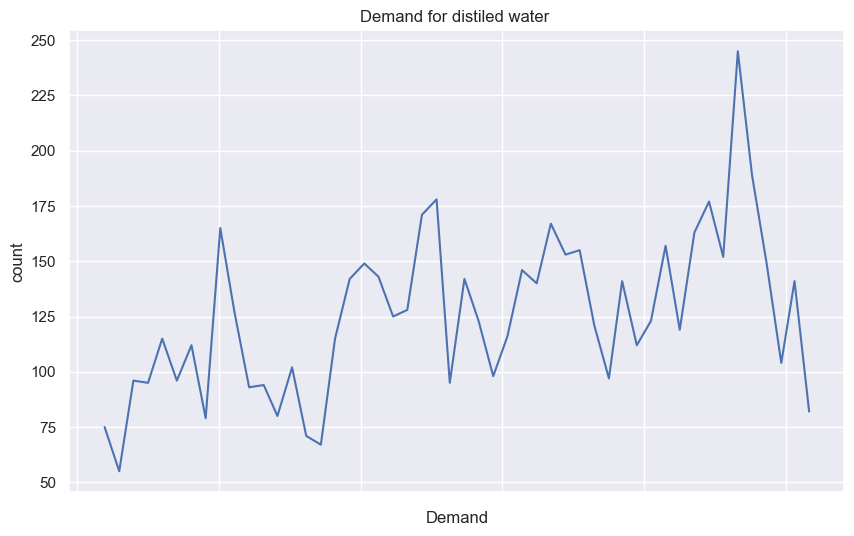

In [95]:
example_df = create_demand_time_series_for(df[df['product_id'] == 30991620])

example_df = example_df[(example_df["date"] > "2019-01-01") & (example_df['date'] < "2024-01-01")]
# example_df['month'] = (example_df.date - pd.to_datetime("2019-01-01")).apply(lambda x: x.days / 30)

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=example_df, x='month', y='count')

plt.title("Demand for distiled water ")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.xlabel("Demand")

ax.set_xticklabels([])
plt.show()

Here we can see how amount of distilled water bottles gradually (visually) rises.

### Seasonal product demand

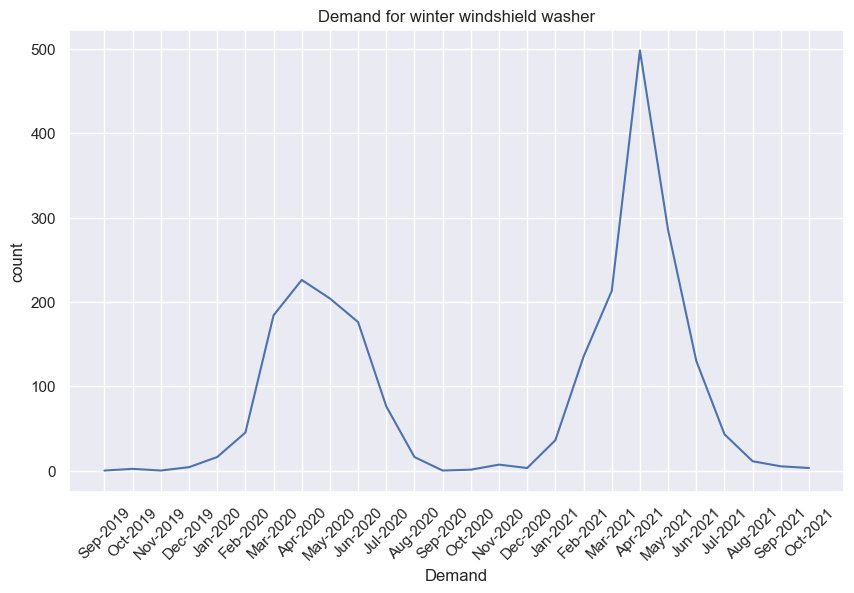

In [96]:
seasonal_product_1 = create_demand_time_series_for(df[df['product_id'] == 37283229])

seasonal_product_1 = seasonal_product_1[(seasonal_product_1["date"] > "2020-05-01") & (seasonal_product_1['date'] < "2022-07-01")]
seasonal_product_1['month'] = example_df.date.dt.strftime("%b-%Y")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=seasonal_product_1, x='month', y='count')

plt.title("Demand for winter windshield washer")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.xlabel("Demand")

plt.show()

Here we depicted demand for windshield washer. We can note a pattern that demand rises around winter. This is understandable as windshield washer is needed only when there is high probability of snow.

### Demand

In [97]:
total_demand_ts = create_demand_time_series_for(df)

total_demand_ts = total_demand_ts[(total_demand_ts["date"] > "2019-02-08") & (total_demand_ts['date'] < "2023-04-30")]
total_demand_ts['month'] = total_demand_ts.date.dt.strftime("%b-%Y")

top_ids = df.groupby('product_id').size().reset_index(name='size').sort_values(by='size', ascending=False).product_id[:4]


top_products_ts = [
    create_demand_time_series_for(df[df['product_id']==product_id])
    for product_id in top_ids
]

top_ids

6427    30991620
7421    37283229
1191     1396584
7261    36926200
Name: product_id, dtype: int64

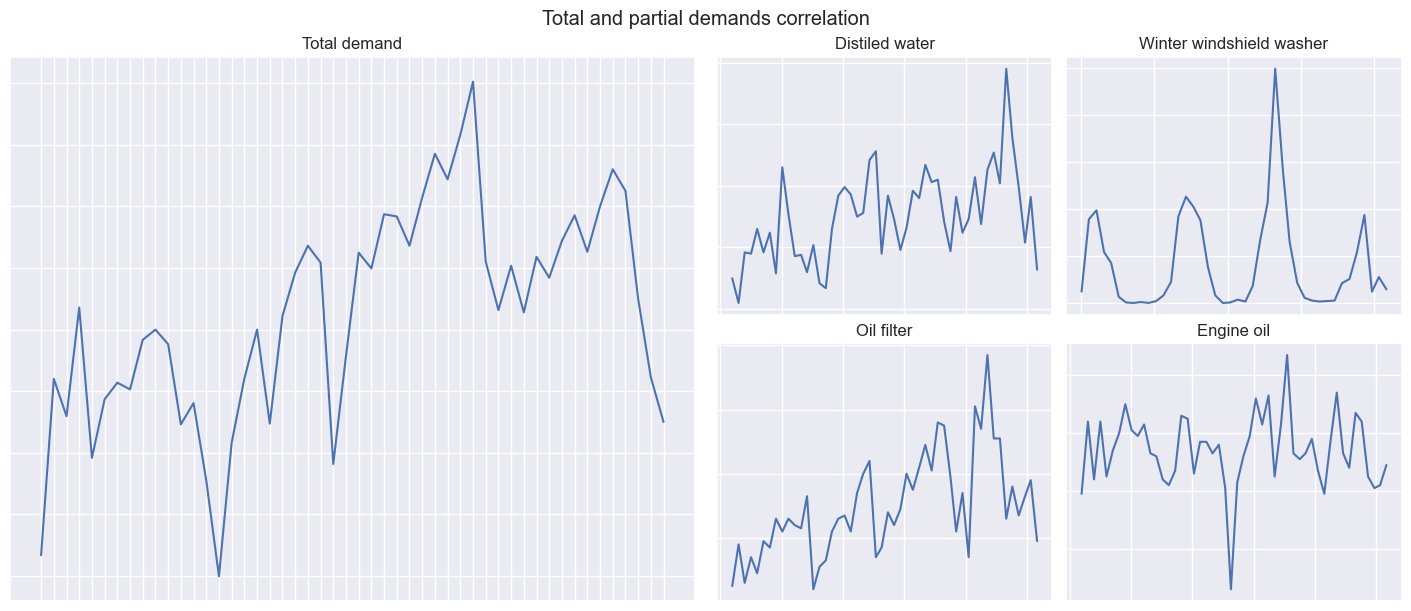

In [98]:

fig = plt.figure(constrained_layout=True, figsize=(14, 6))
fig.suptitle("Total and partial demands correlation")

subfigures = fig.subfigures(nrows=1, ncols=2)


total_ax = subfigures[0].subplots(nrows=1, ncols=1)

sns.lineplot(data=total_demand_ts, x='month', y='count', ax=total_ax)
total_ax.set_title("Total demand")
total_ax.set_xlabel("")
total_ax.set_ylabel("")
total_ax.set_xticklabels([])
total_ax.set_yticklabels([])

sub_axes = subfigures[1].subplots(nrows=2, ncols=2)

sns.lineplot(data=top_products_ts[0], x='month', y='count', ax=sub_axes[0][0])
sub_axes[0][0].set_title("Distiled water")
sns.lineplot(data=top_products_ts[1], x='month', y='count', ax=sub_axes[0][1])
sub_axes[0][1].set_title("Winter windshield washer")
sns.lineplot(data=top_products_ts[2], x='month', y='count', ax=sub_axes[1][0])
sub_axes[1][0].set_title("Oil filter")
sns.lineplot(data=top_products_ts[3], x='month', y='count', ax=sub_axes[1][1])
sub_axes[1][1].set_title("Engine oil")

for i in range(2):
    for j in range(2):
        sub_axes[i][j].set_xlabel("")
        sub_axes[i][j].set_ylabel("")
        sub_axes[i][j].set_xticklabels([])
        sub_axes[i][j].set_yticklabels([])



Here we can see correlation in "demand bumps". For instance distilled water, engine oil and oil filter is common thing for car maintenance, thus the need for it is roughly speaking the same. However, there is strange decline in engine oil demand which should be further investigated.

In [99]:
cross_df = pd.read_csv('dataset_collection/crosses.csv')

`cross_df` is a dataset that matches the match id to a specific product_id (e.g. engine oil of the same characteristics but from different distributors)

In [100]:
top_ids = df.groupby('product_id').size().reset_index(name='size').sort_values(by='size', ascending=False).product_id[:10]
crosses_ids = cross_df[cross_df.product_id.isin(top_ids)].cross_product_id
df[df.product_id.isin(crosses_ids)].groupby('product_id').size().reset_index(name='size').sort_values(by='size', ascending=False)


,product_id,size
13,55253299,1171
12,54881987,1030
1,1775045,988
6,30978375,116
14,59384119,110
4,30978348,109
15,59384124,108
9,32862501,105
8,32804755,100
5,30978360,87


In [101]:
ids = cross_df[cross_df.product_id==1775045].cross_product_id
df[df.product_id.isin(ids)].groupby('product_id').size().reset_index(name='size').sort_values(by='size', ascending=False)

,product_id,size
0,1026969,1964
2,50564040,58
5,54929739,50
3,50564043,41
4,50999841,22
1,1026973,14
6,61690526,2


Here we can see, that some product's analogs may be more popular. (e.g. product `1775045` has total amount, while its `cross_product` with id `1026969` was bought 1964 times)

<Axes: xlabel='month', ylabel='count'>

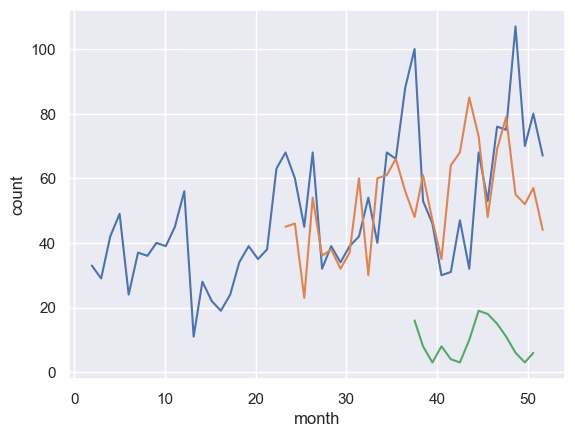

In [102]:
# product_id: 38377622, cross_product_ids: 55253299, 59384119

main_product_ts = create_demand_time_series_for(df[df.product_id==38377622])
cross_1_ts = create_demand_time_series_for(df[df.product_id==55253299])
cross_2_ts = create_demand_time_series_for(df[df.product_id==59384119])


sns.lineplot(data=main_product_ts, x='month', y='count')
sns.lineplot(data=cross_1_ts, x='month', y='count')
sns.lineplot(data=cross_2_ts, x='month', y='count')

This graph depicts demand for different analogues, and we can see clear correlation between items `38377622` and `55253299`. However the third cross product has very short history sales and low demand. Maybe it was the product that company tried to sell, but its analogues have been already recognized on the market, thus the third alternative was not popular.

<Axes: xlabel='month', ylabel='count'>

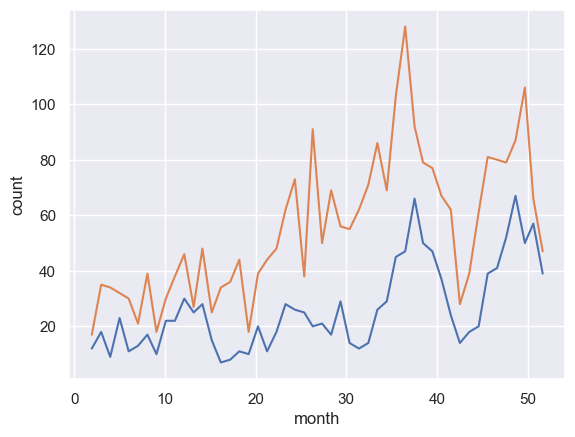

In [103]:
light_ts = create_demand_time_series_for(df[df.product_id==1775045])
cross = create_demand_time_series_for(df[df.product_id==1026969])

sns.lineplot(data=light_ts, x='month', y='count')
sns.lineplot(data=cross, x='month', y='count')

The graph once more shows that demand on analogues is similar.